In [1]:
#IMPORTAZIONE LIBRERIE GENERALI

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 20

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default') # to plot white graphs despite black background
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
#sns.set_style('whitegrid')

from datetime import timedelta
from dateutil.relativedelta import relativedelta

import math

from scipy.stats import norm

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'C:\Users\peria\Desktop\Github\Data Science For Supply Chain Forecasting\norway_new_car_sales_by_make.csv')

data.head()

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4377 entries, 0 to 4376
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      4377 non-null   int64  
 1   Month     4377 non-null   int64  
 2   Make      4367 non-null   object 
 3   Quantity  4377 non-null   int64  
 4   Pct       4377 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 171.1+ KB


In [4]:
def create_period(A):
    
    # Create a double digit month
    A['Month'] = str(A['Month'])
    A['Month'] = '0' + A['Month'] if len(A['Month']) < 2 else A['Month']
    
    # Create Period
    A['Period'] = str(A['Year']) + '-' + A['Month']
    
    return(A)

data = data.apply(create_period, axis = 1)
data.head()

,Year,Month,Make,Quantity,Pct,Period
0,2007,01,Toyota,2884,22.7,2007-01
1,2007,01,Volkswagen,2521,19.9,2007-01
2,2007,01,Peugeot,1029,8.1,2007-01
3,2007,01,Ford,870,6.9,2007-01
4,2007,01,Volvo,693,5.5,2007-01


Da subito ci sono 2 cose da chiedersi:
1) Ci sono dei dati **null** ?

2) Tutte le case automobilistiche hanno macchine vendute in ogni periodo e quindi la sequenza di mesi per ogni casa è sempre completa ?

Come vedremo qui sotto:
1) Sì, ci sono dei dati **null**

2) Sì, alcune case, come la Saab, **hanno meno date degli altri paesi**, quindi bisognerà tenerne di conto

In [5]:
data.isnull().sum()

Year         0
Month        0
Make        10
Quantity     0
Pct          0
Period       0
dtype: int64

In [6]:
data[data['Make'].isnull()]

,Year,Month,Make,Quantity,Pct,Period
37,2007,01,NaN,1,0.0,2007-01
112,2007,03,NaN,1,0.0,2007-03
265,2007,07,NaN,1,0.0,2007-07
419,2007,11,NaN,1,0.0,2007-11
1256,2009,09,NaN,4,0.0,2009-09
1294,2009,10,NaN,4,0.0,2009-10
2399,2012,04,NaN,1,0.0,2012-04
2478,2012,06,NaN,1,0.0,2012-06
2517,2012,07,NaN,1,0.0,2012-07
3013,2013,09,NaN,1,0.0,2013-09


In [7]:
data['Make'].value_counts() # Conto per ogni casa automobilistica il numero di date presenti

Lexus            122
Toyota           121
Mazda            121
Volkswagen       121
Subaru           121
MINI             121
Kia              121
Hyundai          121
Nissan           121
Mitsubishi       121
Renault          121
Fiat             121
Land Rover       121
Suzuki           121
Citroen          121
BMW              121
Mercedes-Benz    121
Honda            121
Audi             121
Opel             121
Skoda            121
Volvo            121
Ford             121
Peugeot          121
Alfa Romeo       117
Jaguar           117
Porsche          117
Smart            110
Jeep             109
Chevrolet         94
Ssangyong         80
Tesla             77
Saab              69
Daihatsu          58
Dacia             56
Nilsson           54
Think             54
Dodge             48
Chrysler          43
Morgan            31
Cadillac          27
Aston Martin      27
Iveco             27
Maserati          26
Ferrari           21
DS                14
Isuzu             14
Lancia       

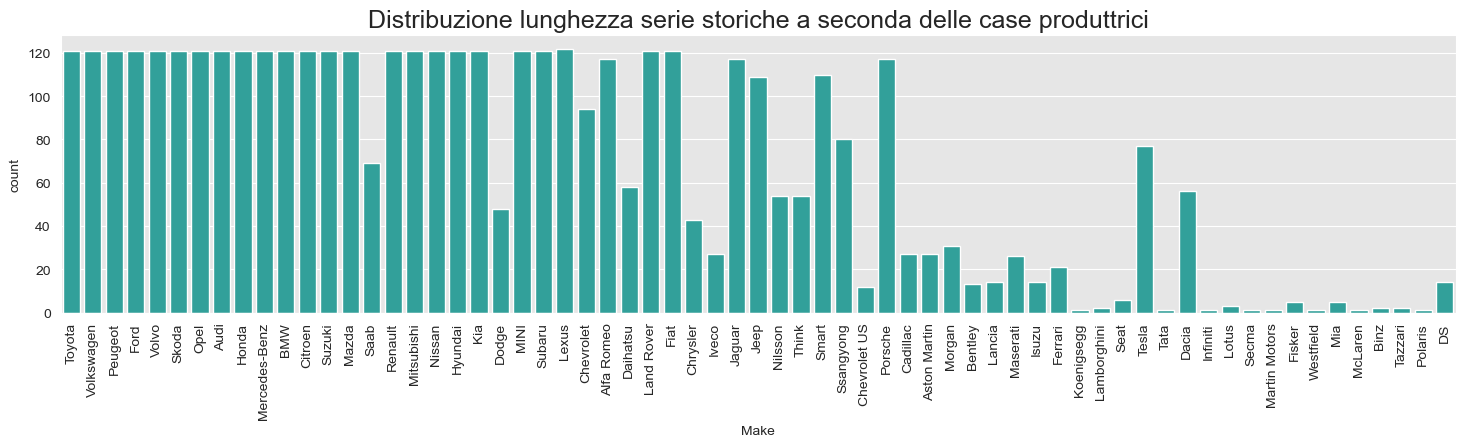

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (18, 3.6))

sns.countplot(x = data['Make'], ax = ax, color = 'lightseagreen')

ax.set_title('Distribuzione lunghezza serie storiche a seconda delle case produttrici', fontsize = 18)

plt.xticks(rotation = 90)

plt.show()

In [9]:
# Per ogni riga, a seconda della casa automobilistica, inserisco il numero di date presenti

def count_len_group(group):
    group['len_group'] = len(group)
    return(group)

data = data.groupby('Make').apply(count_len_group)
data.head()

,Year,Month,Make,Quantity,Pct,Period,len_group
0,2007,01,Toyota,2884,22.7,2007-01,121
1,2007,01,Volkswagen,2521,19.9,2007-01,121
2,2007,01,Peugeot,1029,8.1,2007-01,121
3,2007,01,Ford,870,6.9,2007-01,121
4,2007,01,Volvo,693,5.5,2007-01,121


In [10]:
# Si vede che la Saab salta alcune date, ad esempio manca 2012-09 e 2012-10

data.groupby('Make').get_group('Saab').tail(10)

,Year,Month,Make,Quantity,Pct,Period,len_group
2289,2012,01,Saab,1,0.0,2012-01,69
2321,2012,02,Saab,2,0.0,2012-02,69
2363,2012,03,Saab,1,0.0,2012-03,69
2432,2012,05,Saab,2,0.0,2012-05,69
2473,2012,06,Saab,1,0.0,2012-06,69
2509,2012,07,Saab,2,0.0,2012-07,69
2552,2012,08,Saab,1,0.0,2012-08,69
2659,2012,11,Saab,1,0.0,2012-11,69
2769,2013,02,Saab,1,0.0,2013-02,69
2874,2013,05,Saab,1,0.0,2013-05,69


# PIVOT da data a df

In [11]:
df = pd.pivot_table(data = data, 
                    index = 'Make', columns = 'Period', values = 'Quantity', 
                    aggfunc = 'sum', 
                    fill_value = 0)
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


Nonostante ad alcune case mancassero delle date, qui non vedo valori NaN. Il motivo è che ci ha messo 0. Ad esempio la Saab non ha 2012-09 e 2012-10. Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

In [12]:
# Nonostante ad alcune case mancassero delle date, qui non vedo valori NaN

df.isnull().sum()[df.isnull().sum() == 0].any()

False

In [13]:
# Il motivo è che ci ha messo 0. Ad esempio la Saab non ha 2012-09 e 2012-10
df.loc['Saab', '2012-09':'2012-10']

Period
2012-09    0
2012-10    0
Name: Saab, dtype: int64

#### Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(figsize = [15, 6.5])


for j in ['Saab', 'Citroen', 'Fiat', 'Renault']:
    ax.plot(df.loc[j,:], marker = 'o', markersize = 4, label = j)

step = 4
xlab = [pd.to_datetime(df.columns[0]) + relativedelta(months = j) for j in np.arange(0, len(df.columns), step)]
ax.set_xticklabels(xlab, rotation = 90)
ax.set_xticks(np.arange(0, len(df.columns), step))

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

plt.show()

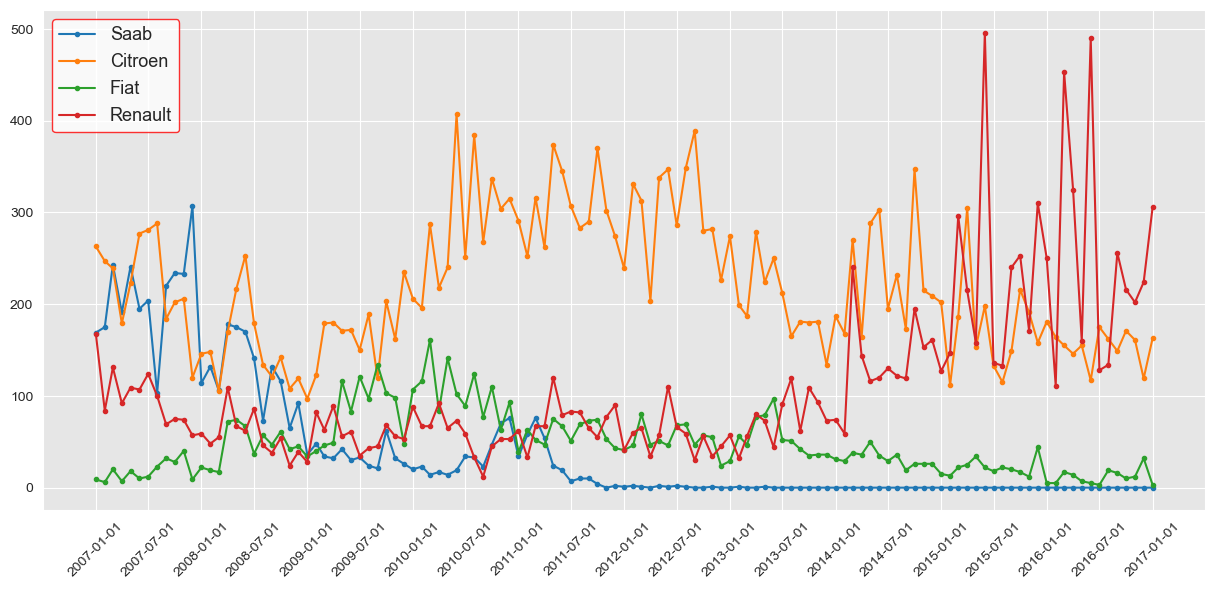

In [14]:
# Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(figsize = [15, 6.5])

df_to_plot = df.T
df_to_plot.index = pd.to_datetime(df_to_plot.index, format = '%Y-%m-%d')

for brand in ['Saab', 'Citroen', 'Fiat', 'Renault']:
    ax.plot(df_to_plot[brand], marker = 'o', markersize = 3, label = brand)

step = 6
ax.set_xticks( df_to_plot.index[ [j for j in np.arange(0, len(df_to_plot.index), step)] ] )
ax.tick_params(axis = 'x', rotation = 45)

ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

plt.show()

In [15]:
###########################################################################################################################

In [16]:
###########################################################################################################################

# Creazione dataset

Esempio con F, H, G solo per capire cosa verrà fatto nella creazione del dataset

In [17]:
F = np.array([[1,2,3], [4,5,6], [7,8,9], [1,2,4]])
H = np.array([[1,5,7], [1,7,8], [7,8,9], [1,2,4]])
G = [F,H]

In [18]:
G = np.vstack(G)
G

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 4],
       [1, 5, 7],
       [1, 7, 8],
       [7, 8, 9],
       [1, 2, 4]])

In [19]:
G_train, G_test = np.split(G, [-1], axis = 1)

G_train, G_test

(array([[1, 2],
        [4, 5],
        [7, 8],
        [1, 2],
        [1, 5],
        [1, 7],
        [7, 8],
        [1, 2]]),
 array([[3],
        [6],
        [9],
        [4],
        [7],
        [8],
        [9],
        [4]]))

In [20]:
U = np.full((6, 1), np.nan)
U

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [21]:
U.ravel()

array([nan, nan, nan, nan, nan, nan])

In [22]:
###########################################################################################################################

Questa riga di codice serve solo per visualizzare la tabella in excel che si vede meglio

In [23]:
#df.to_csv(r'C:\Users\peria\Desktop\DATA SCIENCE\TIME SERIES\Data Science For Supply Chain Forecasting\pivot_norway_new_car_sales_by_make.csv')

Questa immagine è solo esplicativa del processo che si segue per organizzare una tabella che consenta di fare time series forecasting sfruttando le tecniche di machine learning, ma i dati ovviamente non sono quelli stored in df.

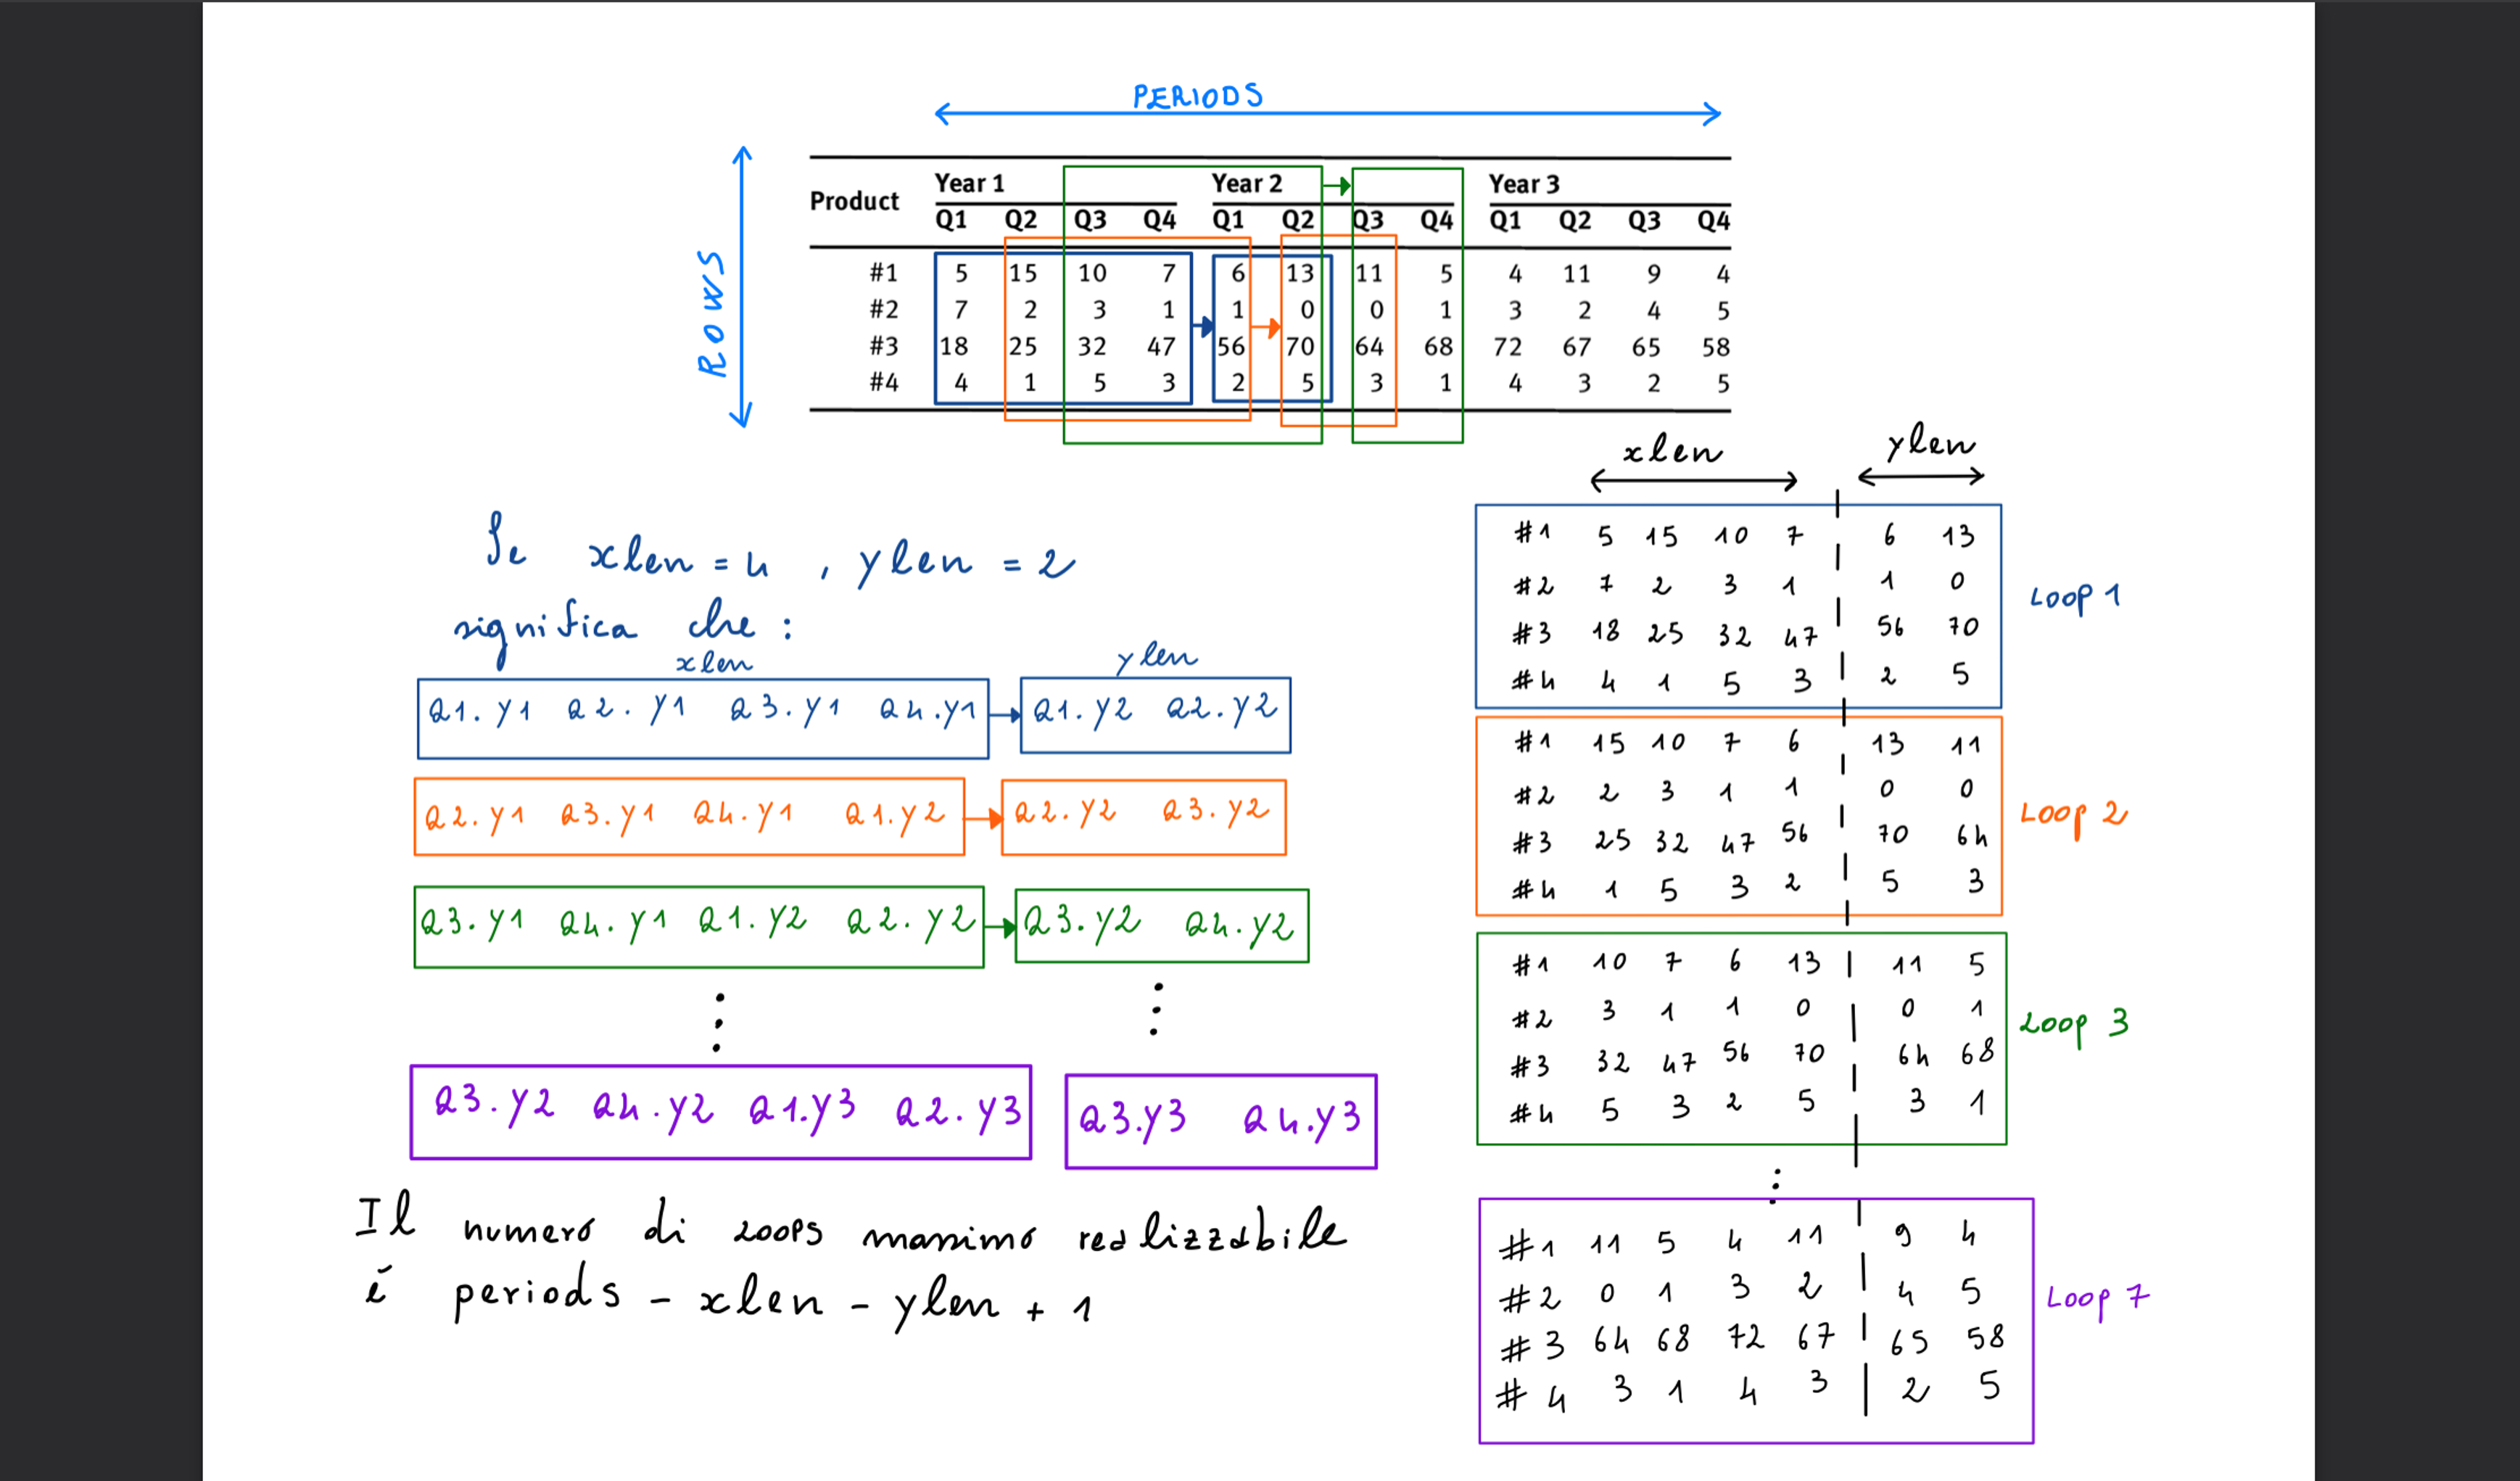

In [24]:
def create_dataframe(A, xlen, ylen, test_loops):
    
    periods_considered = A.columns
    print('1st fitted value on the training set : ', periods_considered[xlen])
    print('Last fitted value on the training set : ', periods_considered[-test_loops-1])
    
    D = A.values
    rows, periods = D.shape
    
    #1) CREAZIONE TRAIN
    
    loops = periods - xlen - ylen + 1
    
    train = [] #diventerà una lista di array che vengono appesi con il ciclo sottostante
    
    # A ogni iterazione appendo un array composto da tutte le righe di A ma solo xlen+ylen colonne di volta in
    # volta spostandosi a destra di 1 colonna
    for col in range(loops): 
        train.append(D[ : , col : col+xlen+ylen ])
    
    # Da una lista di array creo un unico 2d-array dove ogni riga è una macchina e ogni colonna è un periodo:
    # in ogni riga ci sono (xlen+ylen) periodi adiacenti e l'idea è di usare (xlen periodi) per predire 
    # i successivi (ylen periodi)
    train = np.vstack(train)
    
    # Splitto il mio 2d-array in 2 array: X_train e y_train. Nell'argomento di split viene specificato il numero di
    # colonne che deve avere y_train, ovvero ylen e per differenza X_train avrà xlen colonne
    X_train, y_train = np.split(train, [-ylen], axis = 1)
    
    
    # 2) CREAZIONE TEST
    
    # Se voglio fare una validazione e quindi rinunciare a una parte delle osservazioni in fase di training per poi
    # usarle in fase di test, splitto X_train in un X_train più piccolo e in X_test.
    # La stessa identica cosa faccio con y_train
    if test_loops > 0: 
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis = 0)
        print('1st predictable test period : ', periods_considered[-test_loops-ylen+1])
        print('Last predictable test period : ', periods_considered[-1])
        
    # Se invece non voglio fare validazione ma solo forecast futura, utilizzo le ultime xlen colonne di D per 
    # fare la previsione 
    else:
        X_test = D[:, -xlen:] # uso le ultime xlen colonne per fare una previsione
        #X_test = train[-rows:, -xlen:] #alternativamente alla riga sopra
        y_test = np.full((X_test.shape[0], ylen), np.nan) # y_test fatto di NaN ha le stesse righe di X_test e ylen colonne
    
    # In accordo a come vuole gli array scikit-learn
    if ylen == 1:
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        
    return (X_train, y_train, X_test, y_test)

## ATTENZIONE !

- Più xlen è elevato ===> più periodi utilizzo come predittori dell'uscita y ===> meno loop posso eseguire. Paradossalmente se sfruttassi tutti i periodi tranne l'ultimo (i.e. xlen = periods - 1 e ylen = 1) allora il loop sarebbe solo 1


- Se voglio fare previsioni di **più periodi in un colpo** (**i.e. multiple periods time series forecasting con la tecnica multiple regression**) anche questo ci consente di fare meno loop e quindi avere meno righe nel training


- Dovrò poi tenere fuori alcune righe di test che riduce ulteriormente la dimensione del campione su cui si addestrano gli algoritmi


- Se il dataset ha **n periodi** (i.e. n colonne ognuna delle quali è un periodo) ===> **loops = n - xlen - ylen + 1**


- Quando si sceglie la dimensione del test (i.e. il numero di righe di **X_test** e **y_test**, che è ovviamente il solito) è opportuno coprire abbastaza periodi da coprire un intera stagione di lunghezza **slen**. Quindi
    - **loops_test = slen** ===> **len(y_test) = len(X_test) = slen * #prodotti**
    - **loops_train = periods - xlen - ylen + 1 - slen**

In [25]:
#**************************************************************************************************************************

# DT Regressor - previsione periodi multipli => ylen > 1

Il **Decision Tree Regressor** nativamente permette di effettuare la multi-output regression

# Creazione (X_train, y_train, X_test, y_test)

In [26]:
xlen = 12
ylen = 3
loops = df.shape[1] - xlen - ylen + 1
test_loops = 24

(X_train, y_train, X_test, y_test) = create_dataframe(df, xlen = xlen, ylen = ylen, test_loops = test_loops)

1st fitted value on the training set :  2008-01
Last fitted value on the training set :  2015-01
1st predictable test period :  2014-12
Last predictable test period :  2017-01


In [27]:
#X_train

#y_train

#X_test

y_test

array([[   1,    9,    1],
       [   0,    0,    0],
       [ 604,  302,  474],
       ...,
       [2106, 2239, 1688],
       [ 754, 1235, 1158],
       [   0,    0,    0]], dtype=int64)

In [28]:
#y_train[-df.shape[0]:]

In [29]:
print('Dimensioni dataset di training: \n', 'X_train: ', X_train.shape, '\n y_train: ', y_train.shape, '\n\n')
print('Dimensioni dataset di testing: \n', 'X_test: ', X_test.shape, '\n y_test: ', y_test.shape)

Dimensioni dataset di training: 
 X_train:  (5395, 12) 
 y_train:  (5395, 3) 


Dimensioni dataset di testing: 
 X_test:  (1560, 12) 
 y_test:  (1560, 3)


In [30]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=15)

In [31]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model.predict(X_train) # per visualizzare DT fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

print('Train Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

Train Prediction:
 [[1.74893617e+01 1.74212766e+01 1.76425532e+01]
 [3.83738602e-01 4.36550152e-01 4.94300912e-01]
 [5.21014286e+02 5.51514286e+02 5.20614286e+02]
 ...
 [1.68382609e+03 1.73373913e+03 1.82578261e+03]
 [1.13929032e+03 1.01903226e+03 9.07419355e+02]
 [3.83738602e-01 4.36550152e-01 4.94300912e-01]] 

Residuals:
 [[-2.48936170e+00 -9.42127660e+00 -9.64255319e+00]
 [-3.83738602e-01 -4.36550152e-01  5.05699088e-01]
 [-9.20142857e+01 -6.55142857e+01 -4.26142857e+01]
 ...
 [ 2.36173913e+02  2.85260870e+02  2.31217391e+02]
 [-1.89290323e+02  1.05296774e+03 -5.86419355e+02]
 [-3.83738602e-01 -4.36550152e-01 -4.94300912e-01]]


## - - - Calcolo $R^{2}$ - - - 

In [32]:
# Calcolo varianza spiegata del modello

for j in range(ylen):
    std_y_train = y_train[:, j].std()
    std_resid_train = resid_train[:, j].std()
    R_squared = 1 - std_resid_train**2 / std_y_train**2
    print('R^2 previsione perido #', j, ' : ', R_squared)

R^2 previsione perido # 0  :  0.9483540775540277
R^2 previsione perido # 1  :  0.9415357981257579
R^2 previsione perido # 2  :  0.9386829067588871


## - - - Predizione sul test - - -

In [33]:
# Predizione sul TEST
y_pred = model.predict(X_test)

In [34]:
#*************************************************************************************************************************#
#*************************************************************************************************************************#

# - - - Creazione metriche di errore - - - 

Adesso creo un dataset con le metriche di errore

In [35]:
# Definizione della funzione
def ML_forecast_KPI(y_train, y_train_pred, y_test, y_pred):
    
    A = pd.DataFrame(columns = ['MAE%', 'RMSE%', 'BIAS%'], index = ['Train', 'Test'])
    
    # COME IL MODELLO FITTA I DATI
    # Ricorda che in time series forecasting, la performance previsionale sarà buona se il modello fitta bene i dati
    # Questo mi dà la misura di come il modello fitta i dati, ma non è da intendere come previsione, quella si fa sul TEST
    A.loc['Train', 'MAE%'] = np.mean(np.abs(y_train - y_train_pred)) / np.mean(y_train)
    A.loc['Train', 'RMSE%'] = np.sqrt( np.mean((y_train - y_train_pred)**2) ) / np.mean(y_train)
    A.loc['Train', 'BIAS%'] = np.mean(y_train - y_train_pred) / np.mean(y_train)
    
    # PERFORMANCE DI PREVISIONE 
    A.loc['Test', 'MAE%'] = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test)
    A.loc['Test', 'RMSE%'] = np.sqrt( np.mean((y_test - y_pred)**2) ) / np.mean(y_test)
    A.loc['Test', 'BIAS%'] = np.mean(y_test - y_pred) / np.mean(y_test)
    
    # Sistemo il dataframe
    A = A.astype(float).round(4)
    
    print(A)


# Invocazione della funzione
for j in range(ylen):
    print('\nForecasting Period #', j+1)
    ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])


Forecasting Period # 1
         MAE%   RMSE%   BIAS%
Train  0.1826  0.4508  0.0000
Test   0.2272  0.5990  0.0619

Forecasting Period # 2
         MAE%   RMSE%   BIAS%
Train  0.1960  0.4801  0.0000
Test   0.2365  0.6000  0.0471

Forecasting Period # 3
         MAE%   RMSE%  BIAS%
Train  0.2034  0.4918 -0.000
Test   0.2241  0.5664  0.059


# - - - Ottimizzazione del Tree - - - 

### 1) LOSS FUNCTION
Possiamo ottimizzare il DecisionTree in base a diversi parametri di riferimento:
- "squared_error"
- "absolute_error"
- "friedman_mse"
- "poisson"

Il MSE ci mette di meno ad ottimizzarsi, quindi sarà la scelta. Gli altri criteri meno

In [36]:
import time

# Non scelgo su quale periodo futuro considerare le metriche di errore perché faccio l'error complessivo su tutti
# gli orizzonti previsionali (es. considero per ogni articolo l'errore su una forecast che guarda 3 mesi nel futuro)

for criterion in ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']:
    start_time = time.time()
    # Creo l'istanza di Regression Tree
    model = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5, criterion = criterion)
    # Fitto il modello
    model.fit(X_train, y_train)
    # Predico su train e su test
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Valuto i KPI su periodo che mi interessa (0 è il primo, 1 il secondo e 2 il terzo ecc..)
    ML_forecast_KPI( y_train, y_train_pred, 
                     y_test, y_pred )
    print('Criterion: ', criterion, ' ', '{:0.2f} seconds'.format(time.time() - start_time), '\n')

         MAE%   RMSE%  BIAS%
Train  0.1940  0.4746  0.000
Test   0.2293  0.5886  0.056
Criterion:  squared_error   0.04 seconds 

         MAE%   RMSE%   BIAS%
Train  0.1914  0.4929  0.0243
Test   0.2361  0.6193  0.0795
Criterion:  absolute_error   5.66 seconds 

         MAE%   RMSE%   BIAS%
Train  0.1941  0.4768  0.0000
Test   0.2241  0.5729  0.0489
Criterion:  friedman_mse   0.04 seconds 

         MAE%   RMSE%   BIAS%
Train  0.2002  0.4936 -0.0000
Test   0.2484  0.6423  0.0461
Criterion:  poisson   0.07 seconds 



### 2) OVERFITTING PER ALBERO TROPPO PROFONDO

Questa idea è utile perché permette di vedere a che punto il DecisionTreeRegressor overfitta, ovvero il punto in cui l'errore scende sul TRAINING SET, ma aumenta sul TEST set. Questo significa che il modello ha troppa VARIANCE, ovvero ha perso la capacità di generalizzaere. Quindi si adatta perfettamente ai dati di TRAIN, arrivando a prevederli davvero con alta accuratezza, ma appena somministriamo dei nuovi dati, ovvero i dati di TEST, fa una previsione pessima.

Andamento RMSE% sulla previsione del  2 ° periodo previsto: 


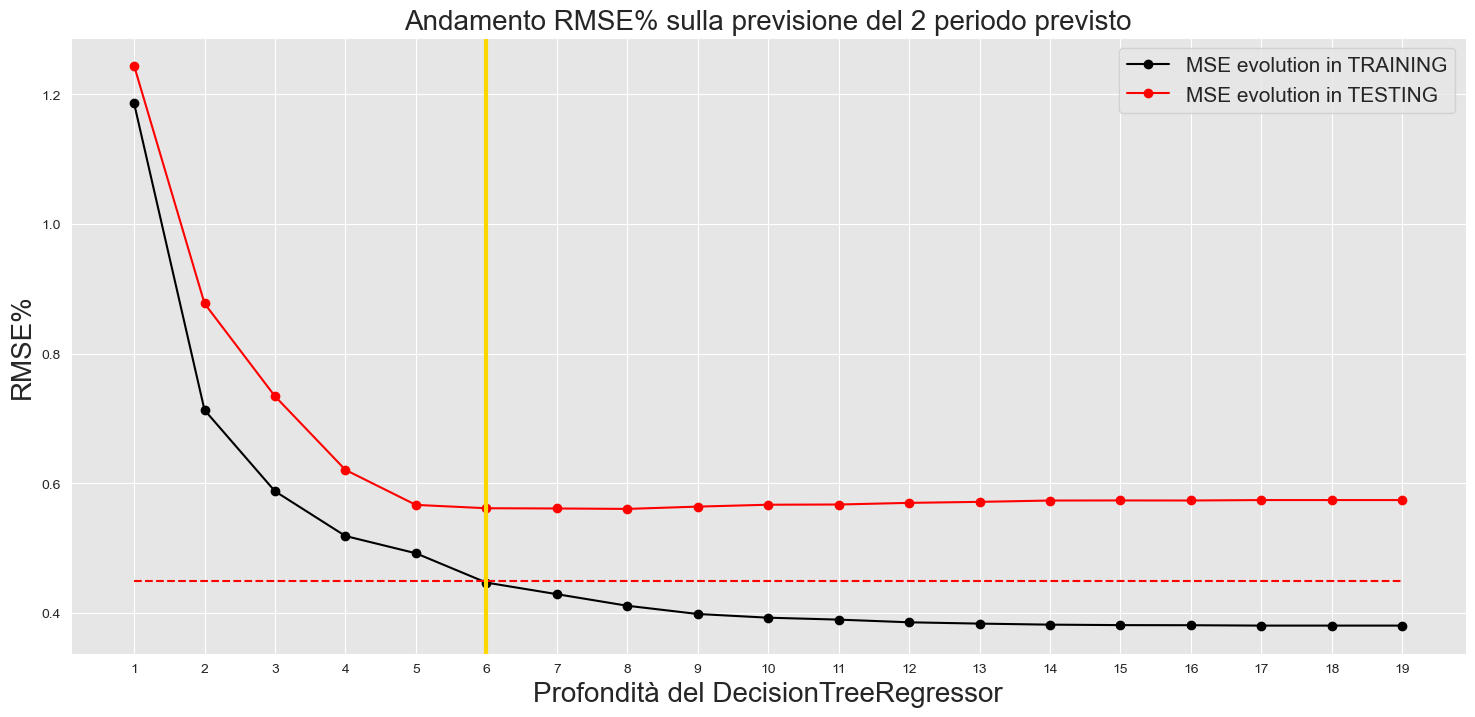

In [37]:
list_MSE_train = []
list_MSE_test = []
Iter = []

#Scelta del periodo futuro di cui considerare la previsione
t = 2

for j in range(1,20):
    
    model = DecisionTreeRegressor( max_depth = j, min_samples_split = 15, min_samples_leaf = 5, criterion = 'squared_error' )
    model.fit(X_train, y_train) # alleno il classificatore
    
    # Valuto il regressore sul TRAIN sul quale l'ho allenato
    y_train_pred = model.predict(X_train)
    MSE_train = np.sqrt( np.mean( (y_train[:, t] - y_train_pred[:, t])**2 ) ) / np.mean(y_train[:, t])
    list_MSE_train.append(MSE_train)
    
    # Valuto il regressore sul TEST 
    y_pred = model.predict(X_test)
    MSE_test =  np.sqrt( np.mean( (y_test[:, t] - y_pred[:, t])**2 ) ) / np.mean(y_test[:, t])
    list_MSE_test.append(MSE_test)
    
    Iter.append(j)
    
    
# PLOT andamento dell'errore sul periodo scelto di interesse
print('Andamento RMSE% sulla previsione del ', t, '° periodo previsto: ')
fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(Iter, list_MSE_train, marker = 'o', c = 'black', label = 'MSE evolution in TRAINING')
ax.plot(Iter, list_MSE_test, marker = 'o', c = 'red', label = 'MSE evolution in TESTING')

best_linear_regression = 0.4488
ax.plot(Iter, np.ones(len(Iter)) * best_linear_regression, color = 'red', linestyle = '--')

ax.axvline(6, color = 'gold', lw = 3)
ax.set_xticks(Iter)
plt.xlabel('Profondità del DecisionTreeRegressor', fontsize = 20)
plt.ylabel('RMSE%', fontsize = 20)
ax.legend(fontsize = 15, loc = 'best')
plt.title('Andamento RMSE% sulla previsione del '+ str(t) + ' periodo previsto', fontsize = 20)
plt.show()

## 3) Cost complexity pruning (weakest link pruning)

In pratica consiste nel costruire un full-sized-Tree $T_{0}$ e di costruire la loss function:

$Loss = SSR + \alpha|T| = \sum_{m=1}^{|T|}{ \sum_{i : x_{i} \in R_{m}}{(y_{i} -\hat{y}_{R_{m}})^{2}}}$

Dove SSR è la somma degli scarti quadratici tra gli elementi nelle varie foglie e le previsioni (ovvero la media di ogni foglia) fatte dal Tree per ogni singola foglia, ovvero regione $R_{m}$.

A questo punto l'idea è quella di mettere in piedi una K-fold Cross-Validation per ottimizzare il valore di $\alpha$.

Sklearn ci viene in aiuto con un costrutto pre-calcolato_ **cost_complexity_pruning_path** che restituisce in 2 attributi:
- ccp_alphas --> i vari alpha esplorati dalla proceduta
- impurities --> i valori della Loss esplorati dall'algoritmo

In [38]:
model = DecisionTreeRegressor(random_state = 0)
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

Text(0.5, 1.0, 'Total Impurity VS Regularization Parameter Alpha on Training Set')

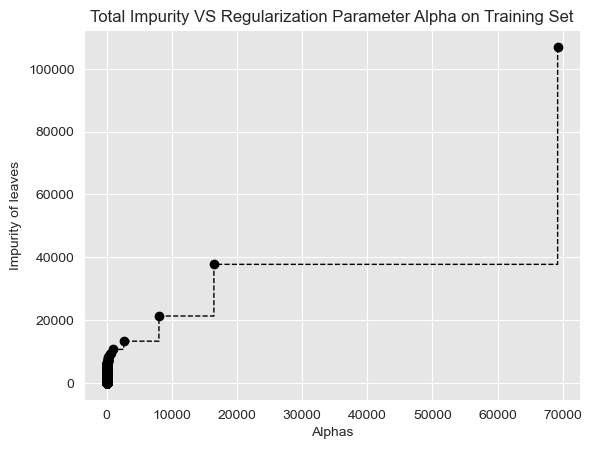

In [39]:
plt.plot(ccp_alphas, impurities, marker = 'o', drawstyle = 'steps-post', color = 'black', linestyle = '--', linewidth = 1)
plt.xlabel('Alphas')
plt.ylabel('Impurity of leaves')
plt.title('Total Impurity VS Regularization Parameter Alpha on Training Set', fontsize = 12)

Adesso faccio il training di vari Regression Tree al variare degli $\alpha$ così ottenuti e ogni volta ne valuto le prestazioni

In [40]:
Trees = []

# Calcolo tutti i Tree al variare di alpha e li memorizzo in Trees
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state = 0, ccp_alpha = alpha)
    model.fit(X_train, y_train)
    Trees.append(model)

print('Il numero di nodi in ultimo Tree è: {} con ccp_alpha: {} '.format(Trees[-1].tree_.node_count, ccp_alphas[-1]))

Il numero di nodi in ultimo Tree è: 1 con ccp_alpha: 69219.1819543636 


In [41]:
# Valuto alcune variabili chiave di ogni Tree
node_count = [model.tree_.node_count for model in Trees]
depth = [model.tree_.max_depth for model in Trees]

# Valuto il MSE come misura di purezza
list_MSE_train = []
list_MSE_test = []
for model in Trees:
    
     # Valuto il regressore sul TRAIN sul quale l'ho allenato
    y_train_pred = model.predict(X_train)
    MSE_train = np.sqrt( np.mean( (y_train[:, t] - y_train_pred[:, t])**2 ) ) / np.mean(y_train[:, t])
    list_MSE_train.append(MSE_train)
    
    # Valuto il regressore sul TEST 
    y_pred = model.predict(X_test)
    MSE_test =  np.sqrt( np.mean( (y_test[:, t] - y_pred[:, t])**2 ) ) / np.mean(y_test[:, t])
    list_MSE_test.append(MSE_test)

min_idx = list_MSE_test.index(min(list_MSE_test))
print('Il minore dei RMSE% si ha per:\n - ccp_alpha -> {}\n - numero_nodi -> {}\n - profondità_albero -> {}\n \
- RMSE% su Train Set -> {}\n - RMSE% su Test Set -> {}'.format( ccp_alphas[min_idx], node_count[min_idx], depth[min_idx],
                                                            list_MSE_train[min_idx], list_MSE_test[min_idx]) )

Il minore dei RMSE% si ha per:
 - ccp_alpha -> 61.11070828769621
 - numero_nodi -> 63
 - profondità_albero -> 8
 - RMSE% su Train Set -> 0.46704231505783056
 - RMSE% su Test Set -> 0.562775829710267


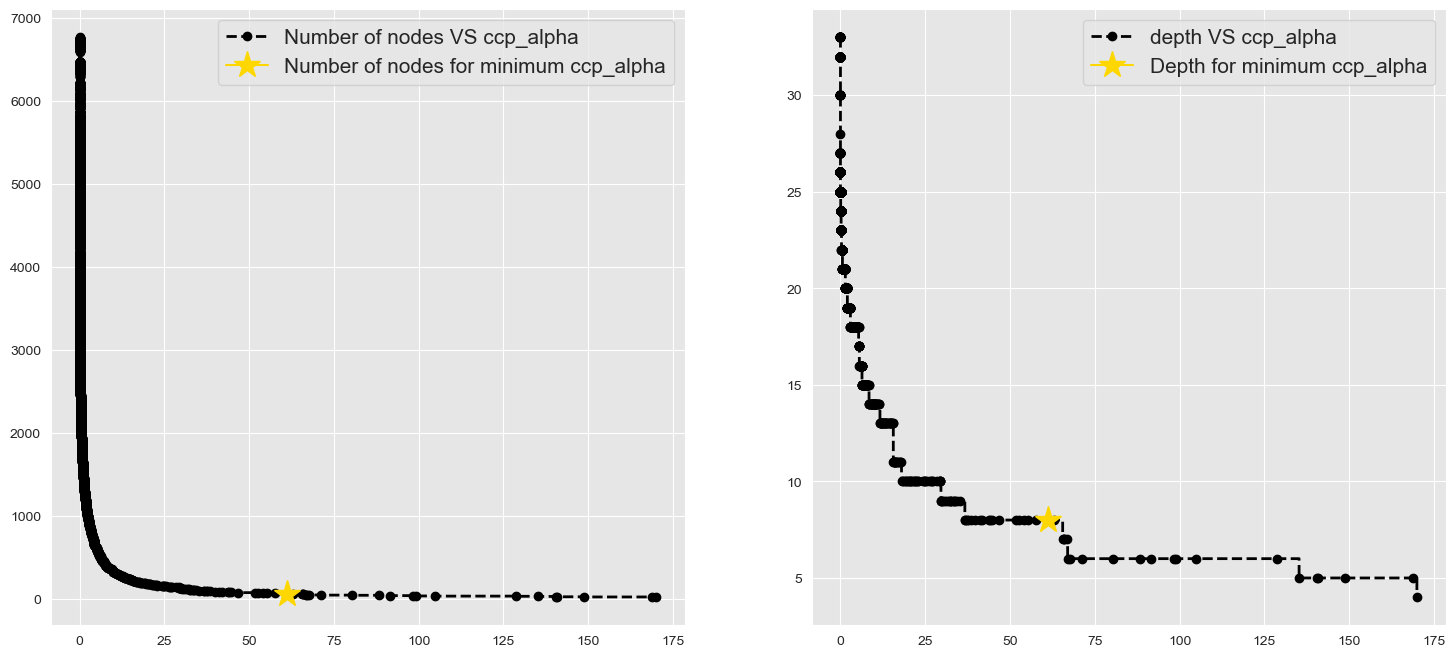

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0].plot(ccp_alphas[:-10], node_count[:-10], marker = 'o', drawstyle = 'steps-post', c = 'black', 
           label = 'Number of nodes VS ccp_alpha', linestyle = '--', linewidth = 2)
ax[0].plot(ccp_alphas[min_idx], node_count[min_idx], marker = '*', c = 'gold', markersize = 20,
           label = 'Number of nodes for minimum ccp_alpha')

ax[1].plot(ccp_alphas[:-10], depth[:-10], marker = 'o', drawstyle = 'steps-post', c = 'black', 
           label = 'depth VS ccp_alpha', linestyle = '--', linewidth = 2)
ax[1].plot(ccp_alphas[min_idx], depth[min_idx], marker = '*', c = 'gold', markersize = 20,
           label = 'Depth for minimum ccp_alpha')



ax[0].legend(fontsize = 15)
ax[1].legend(fontsize = 15)
plt.show()

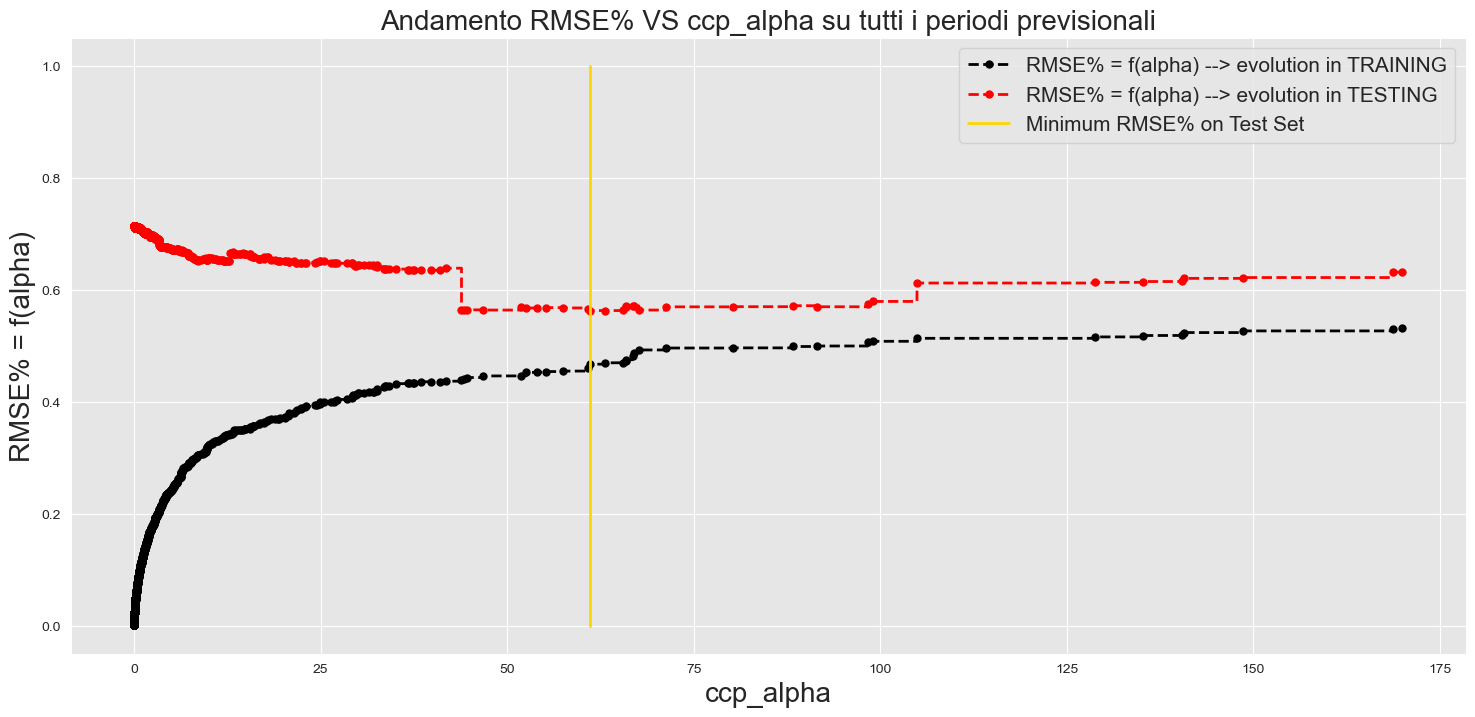

In [43]:
# Plot dell'andamento dell'errore MSE su TRAIN e TEST al variare di alpha 
fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(ccp_alphas[:-10], list_MSE_train[:-10], marker = 'o', markersize = 5, drawstyle = 'steps-post', c = 'black', 
        label = 'RMSE% = f(alpha) --> evolution in TRAINING', linestyle = '--', linewidth = 2)

ax.plot(ccp_alphas[:-10], list_MSE_test[:-10], marker = 'o', markersize = 5, drawstyle = 'steps-post', c = 'red', 
        label = 'RMSE% = f(alpha) --> evolution in TESTING', linestyle = '--', linewidth = 2)

ax.plot(np.ones(2)*ccp_alphas[min_idx], [0, 1], c = 'gold', label = 'Minimum RMSE% on Test Set', linewidth = 2)

plt.xlabel('ccp_alpha', fontsize = 20)
plt.ylabel('RMSE% = f(alpha)', fontsize = 20)
ax.legend(fontsize = 15, loc = 'best')
plt.title('Andamento RMSE% VS ccp_alpha su tutti i periodi previsionali', fontsize = 20)
plt.show()

In [44]:
ccp_alphas[min_idx]

61.11070828769621

In [45]:
# Creo istanza di modello con ccp_alpha scelto
model_Opt = DecisionTreeRegressor(random_state = 0, ccp_alpha = ccp_alphas[min_idx])
# Fitto il modello con alpha scelto
model_Opt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=61.11070828769621, random_state=0)

In [46]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model_Opt.predict(X_train) # per visualizzare DT fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

#print('Train Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

In [47]:
# Calcolo varianza spiegata del modello
for j in range(ylen):
    std_y_train = y_train[:, j].std()
    std_resid_train = resid_train[:, j].std()
    R_squared = 1 - std_resid_train**2 / std_y_train**2
    print('R^2 previsione perido #', j, ' : ', R_squared)

R^2 previsione perido # 0  :  0.9508181219686137
R^2 previsione perido # 1  :  0.9510080812969731
R^2 previsione perido # 2  :  0.9447027561664344


In [48]:
# Predizione sul TEST
y_pred = model_Opt.predict(X_test)

#print('Test Prediction:\n', y_pred, '\n\nTest:\n', y_test)

In [49]:
# Prestazione del migliore stimatore
for j in range(ylen):
    print('\nForecasting Period #', j+1)
    ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])


Forecasting Period # 1
         MAE%   RMSE%   BIAS%
Train  0.1936  0.4399  0.0000
Test   0.2392  0.6160  0.0503

Forecasting Period # 2
         MAE%   RMSE%   BIAS%
Train  0.1977  0.4395  0.0000
Test   0.2486  0.6097  0.0352

Forecasting Period # 3
         MAE%   RMSE%  BIAS%
Train  0.2097  0.4670 -0.000
Test   0.2383  0.5628  0.054


Tuttavia fermarsi qui è una pessima idea, perché semplicemente il TEST set dovrebbe essere utilizzato alla fine dei giochi per valutare la prestazione del modello, non dovrebbe essere utilizzato per ottimizzarci sopra degli iperparametri del modello. Anche perché se così si facesse, il modello imparerebbe benissimo a prevedere i dati di TEST, ancora una volta senza capacità di generalizzare ad altri dati di TEST. In pratica di nuovo overfitting.

Quindi serve una strategia migliore:
- **K-fold Cross Validation**
- **Random Search**

In [50]:
#********************************************************************************************************************************#

### 4) K-fold Cross Validation

Coinvolge ESCLUSIVAENTE i dati del TRAINING. Questo significa che con questa procedura riusciamo ad ottimizzare il modello sui dati di TRAIN e lasciamo il TEST solo alla fine per la valutazione finale della performance predittiva.

La procedura è questa:
1) Dividiamo il TRAIN (non il TEST! quello lo useremo alla fine di tutto come validazione finale) in K differenti sottoinsiemi detti FOLD

2) Alleniamo il nostro modello su tutti i FOLD ad eccezione di uno

3) Utilizziamo il FOLD lasciato fuori come VALIDATION SET per valutare le prestazioni del modello allenato sugli altri (K - 1)-FOLD

4) Ripetiamo 2) e 3) K-volte (dato che ho K-FOLD), cambiando ogni volta il VALIDATION SET. Quando la procedura sarà finita ognuno dei K-FOLD sarà stato una volta VALIDATION SET. Infine mediamo le prestazioni finali ottenute sulle K-VALIDAZIONI e quello sarà il nostro risultato finale

Gli strumemti per mettere in pratica una buona CROSS VALIDATION sono:
- Grid Search CV
- Random Search CV

#### 4.1) Grid Search CV

Viene anche detto ottimizzatore a griglia. In pratica gli fornisco in ingresso una serie di parametri da ottimizzare, con annesso lo spazio dei valori ammissibili. Supponendo che io abbia a disposizione solo Z esperimenti per decretare la migliore combinazione di queste features (e non l'intero spazio di tutte le combinazioni) quello che il Grid Search CV fa è distribuire uniformemente i miei Z esperiementi all'interno dello spazio di tutte le possibili combinazioni.

In [51]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeRegressor()
grid = {'max_depth' : [5, 6, 7, 8, 9, 10],
        'min_samples_split' : [5, 8, 12, 16, 20],
        'min_samples_leaf' : [2, 5, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20]}

model_Opt = GridSearchCV(model, # lo stimatore scelto
                         param_grid = grid, # la griglia di parametri da testare
                         scoring = 'neg_root_mean_squared_error', # lo score in base a cui ottimizzare i parametri
                         cv = 10, # Fold della Cross Validation
                         verbose = 1, # 1, 2, o 3 a secoda di quanto vuoi che scriva man mano che testa
                         n_jobs = -1, # mandare tutti i processori in parallelo
                         refit = True, # refittare lo stimatore in base alla migliore combinazione di parametri testata
                         return_train_score = True)
model_Opt.fit(X_train, y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 5, 8, 10, 12, 14, 15, 16, 17,
                                              18, 19, 20],
                         'min_samples_split': [5, 8, 12, 16, 20]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [52]:
# Visualizzare i migliori parametri
model_Opt.best_params_

{'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 5}

In [53]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model_Opt.predict(X_train) # per visualizzare DT fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

print('Train Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

Train Prediction:
 [[1.58159204e+01 1.62686567e+01 1.57562189e+01]
 [2.19367589e-01 2.90909091e-01 3.42292490e-01]
 [5.52525000e+02 5.99400000e+02 5.63025000e+02]
 ...
 [1.68382609e+03 1.73373913e+03 1.82578261e+03]
 [1.13929032e+03 1.01903226e+03 9.07419355e+02]
 [2.19367589e-01 2.90909091e-01 3.42292490e-01]] 

Residuals:
 [[-8.15920398e-01 -8.26865672e+00 -7.75621891e+00]
 [-2.19367589e-01 -2.90909091e-01  6.57707510e-01]
 [-1.23525000e+02 -1.13400000e+02 -8.50250000e+01]
 ...
 [ 2.36173913e+02  2.85260870e+02  2.31217391e+02]
 [-1.89290323e+02  1.05296774e+03 -5.86419355e+02]
 [-2.19367589e-01 -2.90909091e-01 -3.42292490e-01]]


In [54]:
# Calcolo varianza spiegata del modello
for j in range(ylen):
    std_y_train = y_train[:, j].std()
    std_resid_train = resid_train[:, j].std()
    R_squared = 1 - std_resid_train**2 / std_y_train**2
    print('R^2 previsione perido #', j, ' : ', R_squared)

R^2 previsione perido # 0  :  0.9492650286928623
R^2 previsione perido # 1  :  0.9474360223480871
R^2 previsione perido # 2  :  0.9432956415675628


In [55]:
# Predizione sul TEST
y_pred = model_Opt.predict(X_test)
print('Test Prediction:\n', y_pred, '\n\nTest:\n', y_test)

Test Prediction:
 [[2.80241935e+00 3.89516129e+00 6.50403226e+00]
 [2.19367589e-01 2.90909091e-01 3.42292490e-01]
 [6.08651852e+02 6.20992593e+02 6.09014815e+02]
 ...
 [1.68382609e+03 1.73373913e+03 1.82578261e+03]
 [7.03818182e+02 7.47000000e+02 6.16590909e+02]
 [2.19367589e-01 2.90909091e-01 3.42292490e-01]] 

Test:
 [[   1    9    1]
 [   0    0    0]
 [ 604  302  474]
 ...
 [2106 2239 1688]
 [ 754 1235 1158]
 [   0    0    0]]


In [56]:
# Prestazione del migliore stimatore
for j in range(ylen):
    print('\nForecasting Period #', j+1)
    ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])


Forecasting Period # 1
         MAE%   RMSE%  BIAS%
Train  0.1788  0.4468 -0.000
Test   0.2238  0.5947  0.052

Forecasting Period # 2
         MAE%   RMSE%   BIAS%
Train  0.1832  0.4552  0.0000
Test   0.2350  0.5981  0.0369

Forecasting Period # 3
         MAE%   RMSE%   BIAS%
Train  0.1954  0.4729  0.0000
Test   0.2289  0.5676  0.0496


#### 4.2) Random Search CV

L'idea è leggermente diversa rispetto a quella precedente: invece di cercare i parametri ottimali nello spazio di tutti i parametri disponibili, partendo da una distribuzione a griglia uniforme di tutti questi parametri, il RandomSearchCV cerca i parametri in modo RANDOM. Soprattutto quando i parametri sono molti, di diversa importanza e lo spazio delle possibili soluzioni è molto grande, una ricerca RANDOM paga di più rispetto a una uniforme perché dà la possibilità di testare numerosi valori per i parametri più rilevanti, arrivando a una soluzione potenzialmente migliore.

In [57]:
from sklearn.model_selection import RandomizedSearchCV
model = DecisionTreeRegressor()
dist = {'max_depth' : range(5, 12),
        'min_samples_split' : range(5, 20),
        'min_samples_leaf' : range(2, 20)}

model_Opt = RandomizedSearchCV(model, # lo stimatore scelto
                               param_distributions = dist, # la distribuzione dei parametri da testare
                               scoring = 'neg_root_mean_squared_error', # lo score in base a cui ottimizzare i parametri
                               cv = 10, # Fold della Cross Validation
                               verbose = 1, # 1, 2, o 3 a secoda di quanto vuoi che scriva man mano che testa
                               n_iter = 100, # numero di iterazioni considerate
                               n_jobs = -1, # mandare tutti i processori in parallelo
                               refit = True, # refittare lo stimatore in base alla migliore combinazione di parametri testata
                               return_train_score = True)
model_Opt.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 12),
                                        'min_samples_leaf': range(2, 20),
                                        'min_samples_split': range(5, 20)},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=1)

In [58]:
# Visualizzare i migliori parametri
model_Opt.best_params_

{'min_samples_split': 17, 'min_samples_leaf': 17, 'max_depth': 7}

In [59]:
# PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO
y_train_pred = model_Opt.predict(X_train) # per visualizzare DT fittato su X_train, y_train

# Residui
resid_train = y_train - y_train_pred

#print('Train Prediction:\n', y_train_pred, '\n\nResiduals:\n', resid_train)

In [60]:
# Calcolo varianza spiegata del modello
for j in range(ylen):
    std_y_train = y_train[:, j].std()
    std_resid_train = resid_train[:, j].std()
    R_squared = 1 - std_resid_train**2 / std_y_train**2
    print('R^2 previsione perido #', j, ' : ', R_squared)

R^2 previsione perido # 0  :  0.951823434391469
R^2 previsione perido # 1  :  0.9483526724284629
R^2 previsione perido # 2  :  0.9444153341299042


In [61]:
# Predizione sul TEST
y_pred = model_Opt.predict(X_test)
#print('Test Prediction:\n', y_pred, '\n\nTest:\n', y_test)

In [62]:
# Prestazione del migliore stimatore
for j in range(ylen):
    print('\nForecasting Period #', j+1)
    ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])


Forecasting Period # 1
         MAE%   RMSE%   BIAS%
Train  0.1732  0.4354 -0.0000
Test   0.2214  0.5953  0.0468

Forecasting Period # 2
         MAE%   RMSE%   BIAS%
Train  0.1809  0.4512  0.0000
Test   0.2320  0.5960  0.0372

Forecasting Period # 3
         MAE%   RMSE%   BIAS%
Train  0.1927  0.4683 -0.0000
Test   0.2291  0.5674  0.0478


## Fatures Importance

Con il Decision Tree, tipicamente la feature importance viene calcolata in questo modo. Data la feature $X_{j}$, l'obiettivo è trovare **tutti i nodi** di **tutti gli alberi** che utilizzano $X_{j}$ come splitting variable e calcolare una media su tutti questi nodi, del guadagno di impurità derivante da ciascun split. Facendo la media di tutti i guadagni di impurità / rischi sui nodi, ho quanto in media $X_{j}$ ha contribuito a migliorare la purezza dei vari split

In [63]:
feature_names = np.array(['(T-' + str(12 - j) + ')' for j in range(xlen)])
feature_scores = np.array(model_Opt.best_estimator_.feature_importances_)

# Ordino in base agli scores
_ = np.argsort(feature_scores)[::-1]
feature_names = feature_names[_]
feature_scores = feature_scores[_]

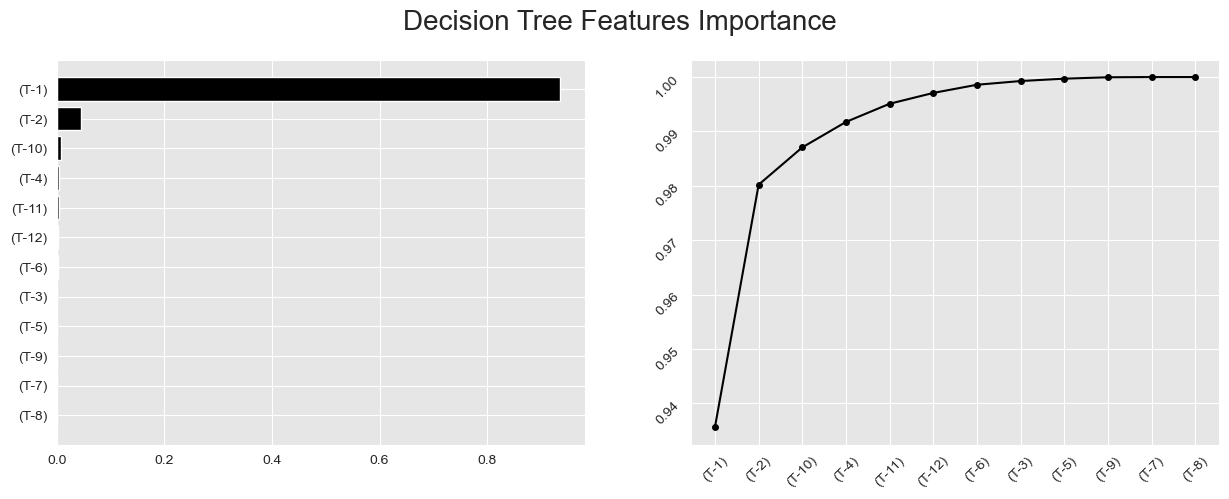

In [64]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].barh(feature_names[::-1], feature_scores[::-1], color = 'black')
ax[1].plot(feature_names, np.cumsum(feature_scores), color = 'black', marker = 'o', markersize = 4)
ax[1].tick_params(rotation = 45)

fig.suptitle('Decision Tree Features Importance', fontsize = 20)
plt.show()

## Visualizing the Tree

In [65]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


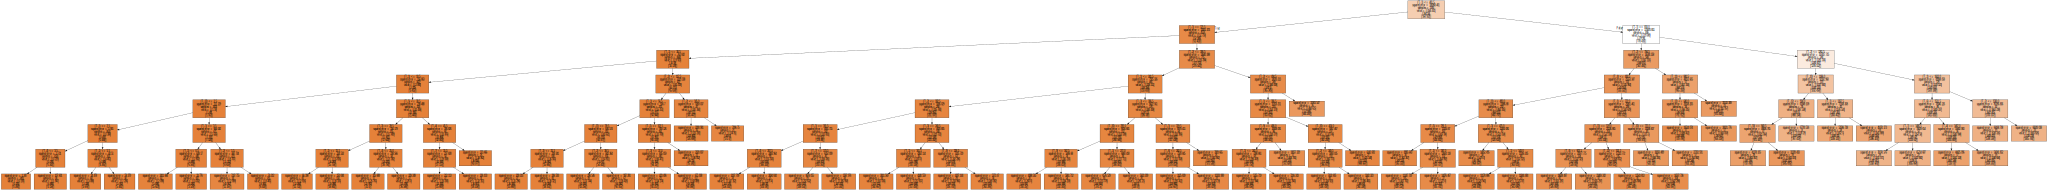

In [76]:
import os
os.environ['PATH'] += os.pathsep + r'C:\Users\peria\Desktop\PYTHON\Graphviz\bin'

features_names = ['(T-' + str(12 - j) + ')' for j in range(xlen)]

from sklearn.tree import export_graphviz
export_graphviz(model_Opt.best_estimator_, out_file='tree.dot', feature_names = features_names, impurity = True, filled = True)

import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [77]:
import pydot
# Usa il tree.dot file per creare il graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Esporta il graph su un file 'tree.png'
graph.write_png('tree.png')

In [67]:
#********************************************************************************************************************************#

In [68]:
#********************************************************************************************************************************#

In [69]:
#********************************************************************************************************************************#

### Riaggregare y_train e y_train_pred in un dataset => df_y_train & df_y_train_pred

In [70]:
# Scegli quale periodo futuro che è stato precedentemente predetto analizzare
t = 2

In [71]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_train = pd.DataFrame(y_train[:, t].reshape((loops-test_loops, -1)).transpose(), 
                              index = df.index,
                              columns = df.columns[(xlen + t) : (-test_loops - ylen + t + 1)])
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    if (-ylen + t + 1) == 0:
        df_y_train = pd.DataFrame(y_train[:, t].reshape((loops, -1)).transpose(), 
                                  index = df.index,
                                  columns = df.columns[(xlen + t) : ])
                                  
    else:
         df_y_train = pd.DataFrame(y_train[:, t].reshape((loops, -1)).transpose(), 
                                  index = df.index,
                                  columns = df.columns[(xlen + t) : (- ylen + t + 1)])

df_y_train.head()

Period,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,...,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,8,9,4,11,15,11,4,9,7,7,...,6,8,4,12,15,8,7,2,1,9
Aston Martin,1,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Audi,478,662,569,693,594,574,545,578,522,625,...,704,721,548,609,575,448,606,516,604,302
BMW,379,593,441,593,386,278,371,395,262,423,...,946,733,644,670,816,670,778,710,804,649
Bentley,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops-test_loops, -1)).transpose(), 
                                   index = df.index,
                                   columns = df.columns[(xlen + t) : (-test_loops-ylen + t + 1)])

else:# Se faccio semplice forecast futura (i.e.test_loops = 0)
    
    if (-ylen + t + 1) == 0:
        df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops, -1)).transpose(), 
                                       index = df.index,
                                       columns = df.columns[(xlen + t) : ])
    else: 
         df_y_train_pred = pd.DataFrame(y_train_pred[:, t].reshape((loops, -1)).transpose(), 
                                       index = df.index,
                                       columns = df.columns[(xlen + t) : (- ylen + t + 1) ])

df_y_train_pred.head()

Period,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,...,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,18.842105,11.712644,8.439024,8.439024,8.439024,8.439024,11.712644,11.712644,11.712644,8.439024,...,8.439024,8.439024,11.712644,8.439024,8.439024,8.439024,11.712644,11.712644,8.439024,8.439024
Aston Martin,0.284109,0.284109,0.284109,0.284109,15.622951,15.622951,15.622951,0.284109,0.284109,0.284109,...,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109
Audi,564.823529,565.225806,464.066667,464.066667,561.695652,561.695652,561.695652,526.068966,565.225806,569.540541,...,569.540541,565.225806,561.695652,622.067308,622.067308,622.067308,622.067308,622.067308,569.540541,569.540541
BMW,439.152381,464.269231,526.068966,444.666667,495.740741,439.152381,495.740741,464.269231,372.823529,373.538462,...,759.785714,759.785714,759.785714,759.785714,729.705882,622.067308,622.067308,620.130435,729.705882,831.529412
Bentley,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,...,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109


### Riaggregare TEST e PREVISIONE in dei dataset => df_y_test e df_y_pred

In [73]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    
    if (-ylen + t + 1) == 0:
        df_y_test = pd.DataFrame(y_test[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):])
    
    else:
        df_y_test = pd.DataFrame(y_test[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops - ylen + t + 1):(-ylen + t + 1)])
    df_y_test.head()
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    print('No df_y_test perché non sono in validazione')

In [74]:
if test_loops > 0 : # Se faccio validazione (i.e. test_loops > 0)
    
    if (-ylen + t + 1) == 0:
        df_y_pred = pd.DataFrame(y_pred[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):])
    
    else:
        df_y_pred = pd.DataFrame(y_pred[:, t].reshape((test_loops, -1)).transpose(), 
                                 index = df.index,
                                 # il +1 perché il secondo estremo non è incluso nello slicing di un array
                                 columns = df.columns[(-test_loops-ylen + t + 1):(-ylen + t + 1)])
    
else: # Se faccio semplice forecast futura (i.e.test_loops = 0)
    df_y_pred = pd.DataFrame(y_pred, index = df.index, columns = ['2017.02', '2017.03', '2017.04'])
    
#df_y_pred = pd.DataFrame(y_pred, index = df.index, columns = '2017.02')
    
df_y_pred.head()

Period,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,3.529412,3.529412,11.166667,3.529412,3.529412,3.529412,3.529412,3.529412,8.439024,8.439024,...,0.284109,15.622951,3.529412,3.529412,15.622951,3.529412,3.529412,11.166667,11.712644,3.529412
Aston Martin,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,...,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109
Audi,565.225806,561.695652,464.269231,622.067308,622.067308,464.066667,561.695652,622.067308,620.130435,565.225806,...,565.225806,622.067308,622.067308,622.067308,622.067308,622.067308,526.068966,620.130435,622.067308,526.068966
BMW,565.225806,831.529412,973.826087,622.067308,620.130435,620.130435,622.067308,620.130435,854.117647,620.130435,...,759.785714,759.785714,1045.894737,759.785714,854.117647,973.826087,854.117647,1045.894737,907.419355,1045.894737
Bentley,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,...,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109,0.284109


### Grafico

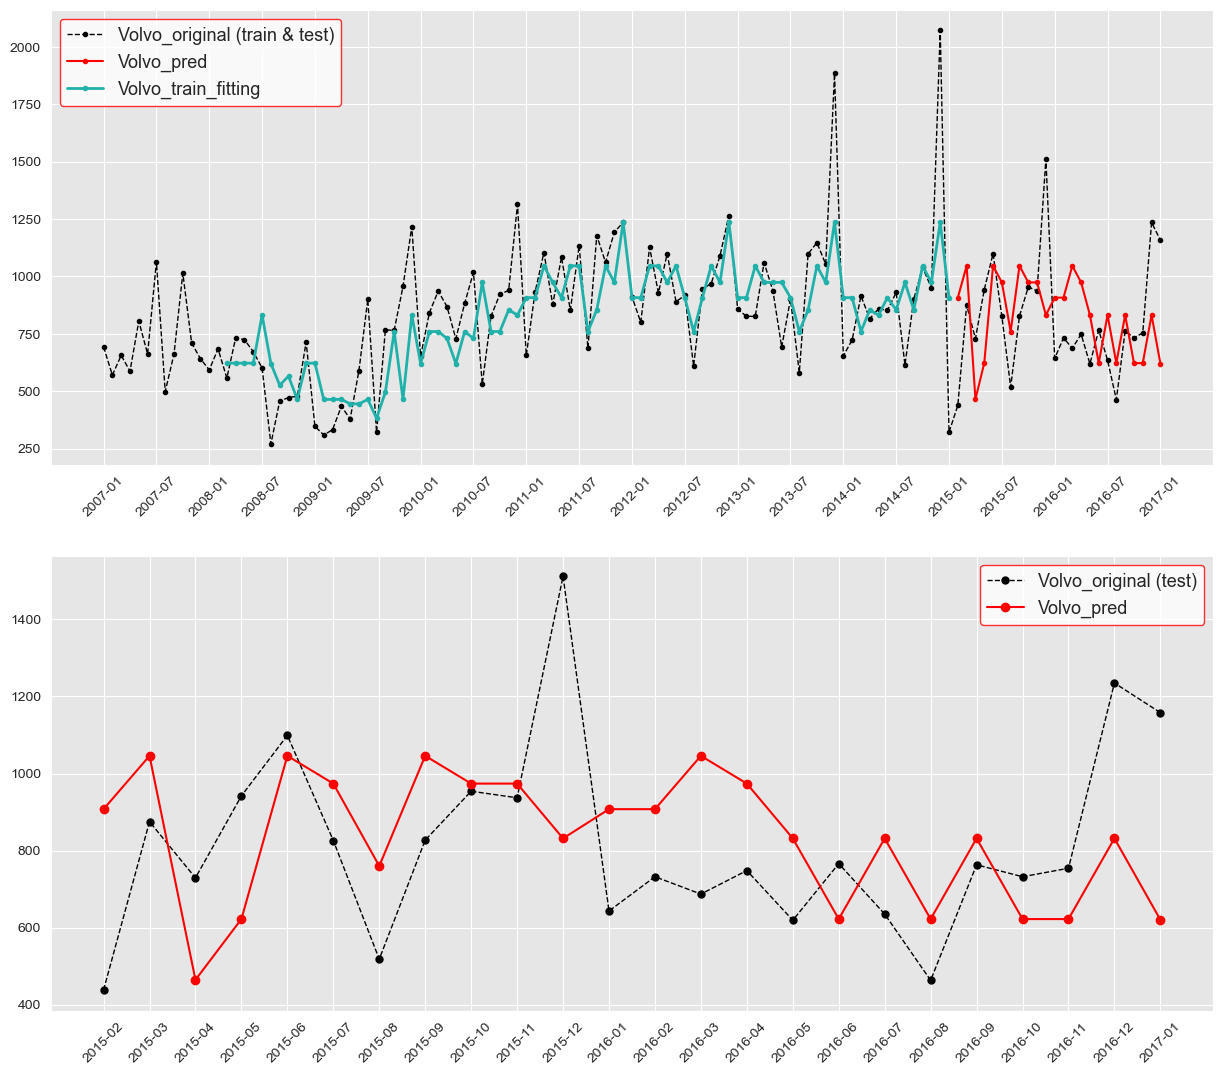

In [75]:
# Quindi adesso posso anche plottare visto che il dataset è completo e tutte le case hanno tutte le date

fig, ax = plt.subplots(2, 1, figsize = [15, 13])

lista_case = ['Volvo']

for brand in lista_case:
    
    # Grafico che mostra l'intera serie + le previsioni + il fitting del train
    ax[0].plot(df.T[brand], marker = 'o', markersize = 3, label = brand + '_original (train & test)', 
               linestyle = '--', lw = 1, c = 'black')
    
    ax[0].plot(df_y_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_pred', c = 'red')
    ax[0].plot(df_y_train_pred.T[brand], marker = 'o', markersize = 3, label = brand + '_train_fitting', 
               lw = 2, c = 'lightseagreen')

    # Focus esclusivamente sulle previsioni
    ax[1].plot(df_y_test.T[brand], marker = 'o', markersize = 5, label = brand + '_original (test)', 
               linestyle = '--', linewidth = 1, c = 'black') if test_loops > 0 else '' # se non sono in validazione
    ax[1].plot(df_y_pred.T[brand], marker = 'o', label = brand + '_pred', c = 'red')

# Disegno la griglia ascisse dell'intera serie su ax[0]

step = 6
ax[0].set_xticks( df.T.index[ [j for j in np.arange(0, len(df.T.index), step)] ] )
ax[0].tick_params(axis='x', rotation=45)    
# Disegno la griglia ascisse dell'intera serie su ax[1]

step = 1
ax[1].set_xticks( df_y_pred.T.index[ [j for j in np.arange(0, len(df_y_pred.T.index), step)] ] )
ax[1].tick_params(axis='x', rotation=45)

# Legend
ax[0].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')
ax[1].legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')

#plt.savefig(r'C:\Users\peria\Desktop\Img.png')

plt.show()